In [62]:
# Importing the libraries 
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model

In [63]:
data = pd.read_csv('data.csv')

### This dataset contains information about the pricing of houses around Boston Area.The dataset has information on 14 variables on 506 observations.

In [64]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [65]:
#Checking for missing values
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         5
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [66]:
#imputing the missing values with the median

# Calculate the median of the column (ignoring missing values)
median_value = data['RM'].median()

# Replace missing values with the median
data['RM'].fillna(median_value, inplace=True)

In [67]:
#Splitting the data into Response and Predictors

y = data['MEDV']
X = data.drop('MEDV' , axis = 1)

### Before fitting the Multiple Linear Regression model, we would check for the assumptions of Linear Regression. 


## 1) Normality Assumption:
#### we would test for the normality of the response variable. So, we would be observing the QQ-Plot of the response variables to determine normality.

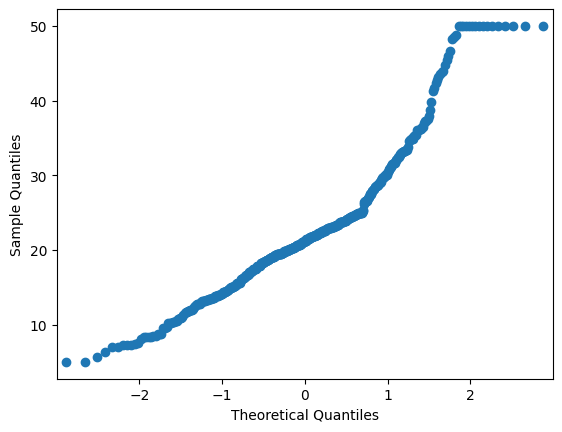

In [68]:
p = sm.qqplot(y)

## Box-Cox Transformation

### we would apply the one parameter Box-Cox Transformation so that the response variable follows a normal distribution.

Estimated Lambda: 0.4212062495083248


(array([  6.,  18.,  27.,  65., 110., 148.,  48.,  40.,  15.,  13.]),
 array([2.30231007, 3.05556029, 3.80881051, 4.56206072, 5.31531094,
        6.06856115, 6.82181137, 7.57506159, 8.3283118 , 9.08156202,
        9.83481223]),
 <BarContainer object of 10 artists>)

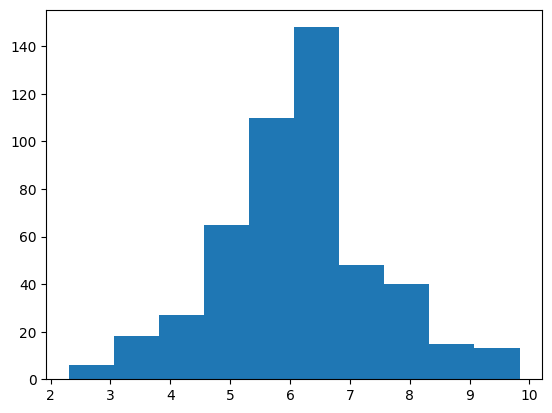

In [78]:
data = data[data['MEDV'] != 50]
y = data['MEDV']
X = data.drop('MEDV' , axis = 1)

# Perform Box-Cox transformation
transformed_data, lambda_value = stats.boxcox(y)

# Print the estimated lambda value
print("Estimated Lambda:", lambda_value)

y_trans = (pow(y , lambda_value) - 1)/lambda_value

#Plotting the transformed variable.
plt.hist(y_trans)

## Test for Normality
### D’Agostino’s K-squared test: This tests whether a sample differs from a normal distribution.
#### H0 = The sample comes from a normal distribution.
#### HA =The sample is not coming from normal distribution.

In [71]:
a , b = stats.normaltest(y_trans)
if b < 0.05:
    print("Does not follow normality")
else:
    print("Follows normality")

Follows normality


## 2) Homoscedasticity:
#### we need to verify whether that the variance of the residuals is constant across all levels of the independent variable(s). If the variance of the residuals changes with the predicted values or the independent variable(s), the errors are heteroscedastic.

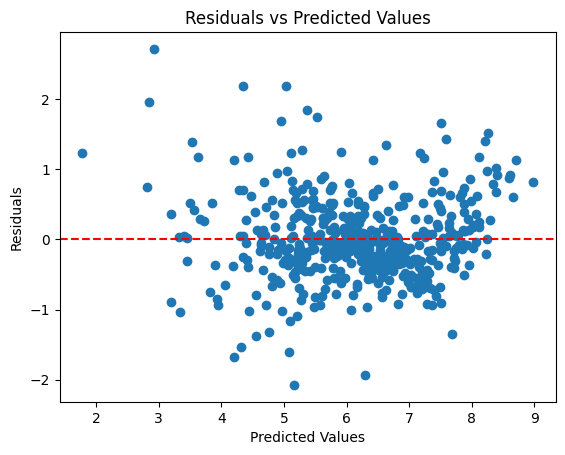

In [120]:
# Fit the linear regression model
X_const = sm.add_constant(X)  # Add a constant term for the intercept
model = sm.OLS(y_trans, X_const)
results = model.fit()

# Obtain the residuals
residuals = results.resid

# Create a scatter plot of residuals vs predicted values
plt.scatter(results.fittedvalues, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

#### We fitted the regression model using all predictors and plotted the residuals vs the predicted values. From the graph, it is observed that the residuals are randomly scattered  around the zero line without any clear pattern. Thus we can consider the residuals to be homoscedastic.

## 3) Multicollinearity:

#### It is a phenomenon that occurs in multiple linear regression when two or more independent variables are highly correlated with each other. Detecting multicollinearity involves examining the correlation matrix or using statistical measures like the Variance Inflation Factor (VIF). If the VIF of an independent variable is significantly higher than 1 (commonly, VIF > 5 or 10 is considered problematic), it indicates multicollinearity.

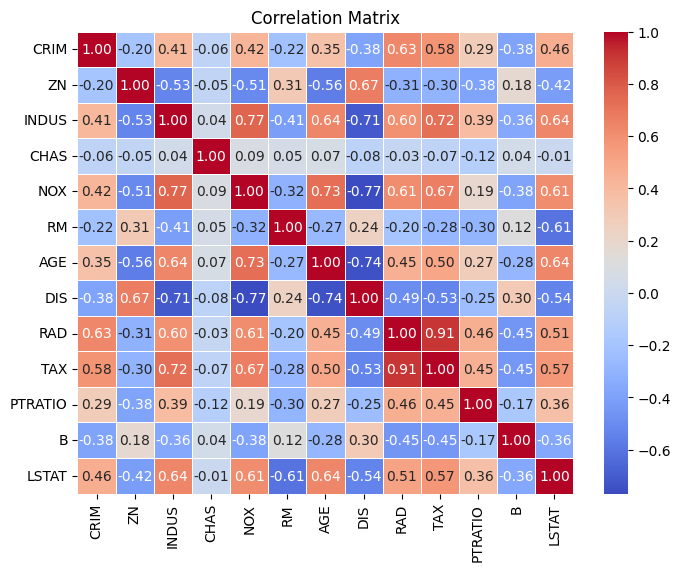

In [73]:
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [74]:
# VIF technique

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Variable'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Display the VIF values
print(vif)

   Variable         VIF
0     const  584.866088
1      CRIM    1.794280
2        ZN    2.292197
3     INDUS    3.996622
4      CHAS    1.063103
5       NOX    4.394686
6        RM    1.865785
7       AGE    3.103301
8       DIS    3.974782
9       RAD    7.351419
10      TAX    8.789060
11  PTRATIO    1.710967
12        B    1.347145
13    LSTAT    3.114147


### We observe that the VIF value of TAX is significantly high indicating that it needs to be dropped. After droping the TAX variable, we again calulate the VIF to make sure that multicollinearity has been iradicated from the dataset.

In [79]:
vif = pd.DataFrame()
vif['Variable'] = X_const.drop('TAX' , axis = 1).columns
vif['VIF'] = [variance_inflation_factor(X_const.drop('TAX' , axis = 1).values, i) for i in range(X_const.drop('TAX' , axis = 1).shape[1])]

# Display the VIF values
print(vif)

   Variable         VIF
0     const  578.564991
1      CRIM    1.793849
2        ZN    2.170020
3     INDUS    3.310304
4      CHAS    1.043315
5       NOX    4.365764
6        RM    1.858479
7       AGE    3.102483
8       DIS    3.974573
9       RAD    2.842334
10  PTRATIO    1.700200
11        B    1.346126
12    LSTAT    3.114057


## 4) Absence of Outliers
### Before fitting the regression model, we need to make sure that outliers/inferential points are absent in the data. We would be using Cook's Distance Method for detection and removal of outliers.

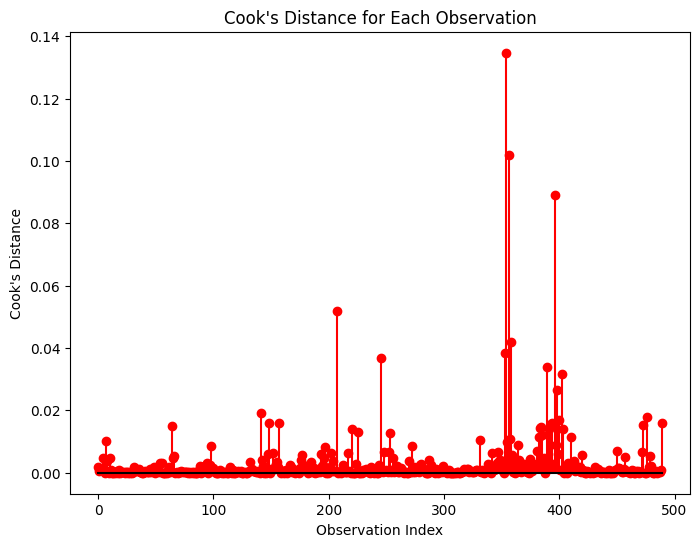

In [87]:
from statsmodels.stats.outliers_influence import OLSInfluence
# Calculate Cook's distance for each observation
influence = OLSInfluence(results)
cooks_distance = influence.cooks_distance[0]

# Plot Cook's distance for each observation
plt.figure(figsize=(8, 6))
plt.stem(cooks_distance, linefmt='r-', markerfmt='ro', basefmt='k-')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

### A popular choice of cut-point for Cook's Distance is 1. Thus, we can observe that cook's distance didn't cross the value 1 for any of the observations. So, we can conclude that outliers are absent in the dataset.

## Feature Selection
### Now, our job is to select a smaller subset of feeatures from a larger set. By performing such variable selection, we seek for a trade off between the biasedness and the variances of the estimates of the features retained, thereby, reducing the complexity of the model.

### Here, we would be using the Backward Stepwise Selection Method for variable selection.

In [118]:
##Backward Stepwise Selection

X_const = X_const.drop('TAX' , axis = 1)
feature = list(X_const)
data = pd.DataFrame(X_const , columns=feature)
data['target'] = y_trans


model = sm.OLS(data['target'] , data.drop(['target'] , axis=1)).fit()
selected_features = feature


while len(selected_features) > 1:
    p_values = model.pvalues[1:]
    max_p_value_idx = np.argmax(p_values)
    if p_values[max_p_value_idx] <= 0.05:
        break
    feature_to_remove = selected_features[max_p_value_idx + 1]  
    selected_features.remove(feature_to_remove)
    model = sm.OLS(data['target'], data[selected_features]).fit()
    
print("the important features are \n")
print(selected_features)

the important features are 

['const', 'CRIM', 'INDUS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']


## Fitting a Multiple Linear Regression Model using the above selected Features

In [119]:
pred = X_const[selected_features]
resp = y_trans

model = sm.OLS(y_trans , pred)
results_final = model.fit()

print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     193.4
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          1.85e-153
Time:                        03:38:01   Log-Likelihood:                -458.06
No. Observations:                 490   AIC:                             936.1
Df Residuals:                     480   BIC:                             978.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7509      0.673     13.004      0.0

## Conclusion

#### The main objective of the project is to determine the most significant features which affects the house pricing around Boston. Various Feature Engineering Processes like Box-Cox Transformation and Outliers Removals has been carried out sucessfully. Before going for the model fitting, it has been made sure, that all the assumptions of Linear Regression has been followed. After feature selection using Backward Stepwise Elimination, a MLR model has been fitted on the data. From the model, we can conclude that, Crime-Rates(CRIM), average number of rooms per dwelling(RM) , pupil-teacher ratio by town(PTRATIO) and Pollution-levels (NOX) plays a significant role in determning the house prices. People prefer to live in peace-loving and pollution-free environment, therefore, houses in these areas are of higher values. We can also infer that people favours the places having relatively lower teacher-pupil ratio. Distance of Charles River also plays a vital role in determinig the house prices. People always prefer to live in urban areas, so housing prices increases where the percentage of lower sections of the population are considerably less.